# Handling and analysis of all measured data + genetic data in the form of PCA components

#### Imports of all modules and external functions used

In [1]:
# import os for better file handling
import os


# standard library utilized in many calculations
import numpy as np


# standard library for handling data in a spreadsheet like manner
import pandas as pd


# standard library for plotting data 
import matplotlib.pyplot as plt
from matplotlib import transforms

# for overlaying images on top of plots
from matplotlib.offsetbox import OffsetImage
from matplotlib.offsetbox import AnnotationBbox

# another library used mainly for conviently plotting heat maps
import seaborn as sns


# functions for cluster analysis and dimension reduction
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing


# various functions for calculating relations between samples, standardization etc.
from scipy.cluster import hierarchy as hc
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix


# most used functions for calculating the amounts of variability in numeric and categorical variables
from scipy.stats import pearsonr
from scipy.stats import entropy 

#### Reading in all of the measurements

In [2]:
with open("alldata_cleaned.csv") as file:
    df = pd.read_csv(file, sep=";", decimal=",", na_values="-")

alldata=df.copy()

#Checking the first lines
alldata.head()

,SAMPLE,LUKE,principal component 1,principal component 2,TIME,LEAF MARGIN,ABAXIAL INDUMENTUM,PEONY HEIGHT,LEAF HEIGHT,UPRIGHTNESS,...,SHAPE,FRAGRANCE,CHL,CHL_SD,FLAV,FLAV_SD,ANTH,ANTH_SD,NBI,NBI_SD
0,25,LUKE-5050,-2.391752,-1.040240,2,RED,NO,790,560,1,...,DOUBLEZONES,NORMAL,35.891,2.710,1.683,0.235,0.127,0.032,21.798,4.162
1,26,LUKE-5051,0.142760,1.650453,1,RED,NO,870,640,2,...,DOUBLE,PLASTICKY,41.779,5.107,1.679,0.135,0.104,0.027,24.885,2.463
2,27,LUKE-5052,-1.264539,-0.891731,1,RED,NO,790,590,1,...,CROWN,SWEET,32.530,5.232,1.606,0.142,0.146,0.023,20.323,3.181
3,30,LUKE-4901,1.592366,1.168089,1,RED,NO,860,630,2,...,DOUBLE,PLASTICKY,27.665,3.136,1.542,0.250,0.176,0.021,18.228,2.640
4,32,LUKE-3425,-0.235052,-1.114539,1,BROWN,NO,920,610,1,...,CROWN,NORMAL,35.704,2.506,1.574,0.149,0.145,0.045,23.216,2.116


#### Removing the genetic data values from the data set into a separate list 

In [3]:
# The examined features are the columns of the measurement data
features = list(alldata.columns)

# Removing the LUKE codes from the dataset, while storing the codes to variable named lukecodes
lukecodes = alldata["LUKE"]
unnecessary_columns = ["LUKE"]
for i in unnecessary_columns:
    features.remove(i)

components = pd.DataFrame(data=alldata, columns=["principal component 1", "principal component 2", "SAMPLE"])

components = components.set_index("SAMPLE")
#principal components ordered by the sample names


# Removing the genetic data, which has been converted to principal component values, from the dataset, while storing the components in a separate list called principal_components
principal_components = ['principal component 1',
 'principal component 2']

for i in principal_components:
    features.remove(i)

# Single variable for referencing the measured features without the genetic data
measured_data = alldata[features]
measured_data.head()

,SAMPLE,TIME,LEAF MARGIN,ABAXIAL INDUMENTUM,PEONY HEIGHT,LEAF HEIGHT,UPRIGHTNESS,PEDUNCLE LENGTH,FLOWER DIAMETER,FLOWER HEIGHT,...,SHAPE,FRAGRANCE,CHL,CHL_SD,FLAV,FLAV_SD,ANTH,ANTH_SD,NBI,NBI_SD
0,25,2,RED,NO,790,560,1,10.3,144,52,...,DOUBLEZONES,NORMAL,35.891,2.710,1.683,0.235,0.127,0.032,21.798,4.162
1,26,1,RED,NO,870,640,2,12.0,139,63,...,DOUBLE,PLASTICKY,41.779,5.107,1.679,0.135,0.104,0.027,24.885,2.463
2,27,1,RED,NO,790,590,1,8.0,127,50,...,CROWN,SWEET,32.530,5.232,1.606,0.142,0.146,0.023,20.323,3.181
3,30,1,RED,NO,860,630,2,10.7,126,39,...,DOUBLE,PLASTICKY,27.665,3.136,1.542,0.250,0.176,0.021,18.228,2.640
4,32,1,BROWN,NO,920,610,1,9.3,158,72,...,CROWN,NORMAL,35.704,2.506,1.574,0.149,0.145,0.045,23.216,2.116


## Calculating the genetic distances between the samples into a new dataframe 

In [4]:
# genetic distances as a 2 dimensional matrix representation
pairwise = pd.DataFrame(
    squareform(pdist(components)),
    columns = components.index,
    index = components.index
)
pairwise = pairwise.rename_axis(None)

#scaling of distance values 0 to 1
distance_values = pairwise.values
min_max_scaler = preprocessing.MinMaxScaler()
distance_values_skaalattu = min_max_scaler.fit_transform(distance_values)

#Distance values into a new dataframe for plotting 
pairwise_scaled = pd.DataFrame(distance_values_skaalattu, columns = components.index,
    index = components.index)

# Replace the values with 1-value, so that a higher value depicts closer distance 
pairwise_scaled_flipped = pairwise_scaled.applymap(lambda x: 1-x)

### Plotting the genetic distances in a heat map

<Figure size 2000x2000 with 0 Axes>

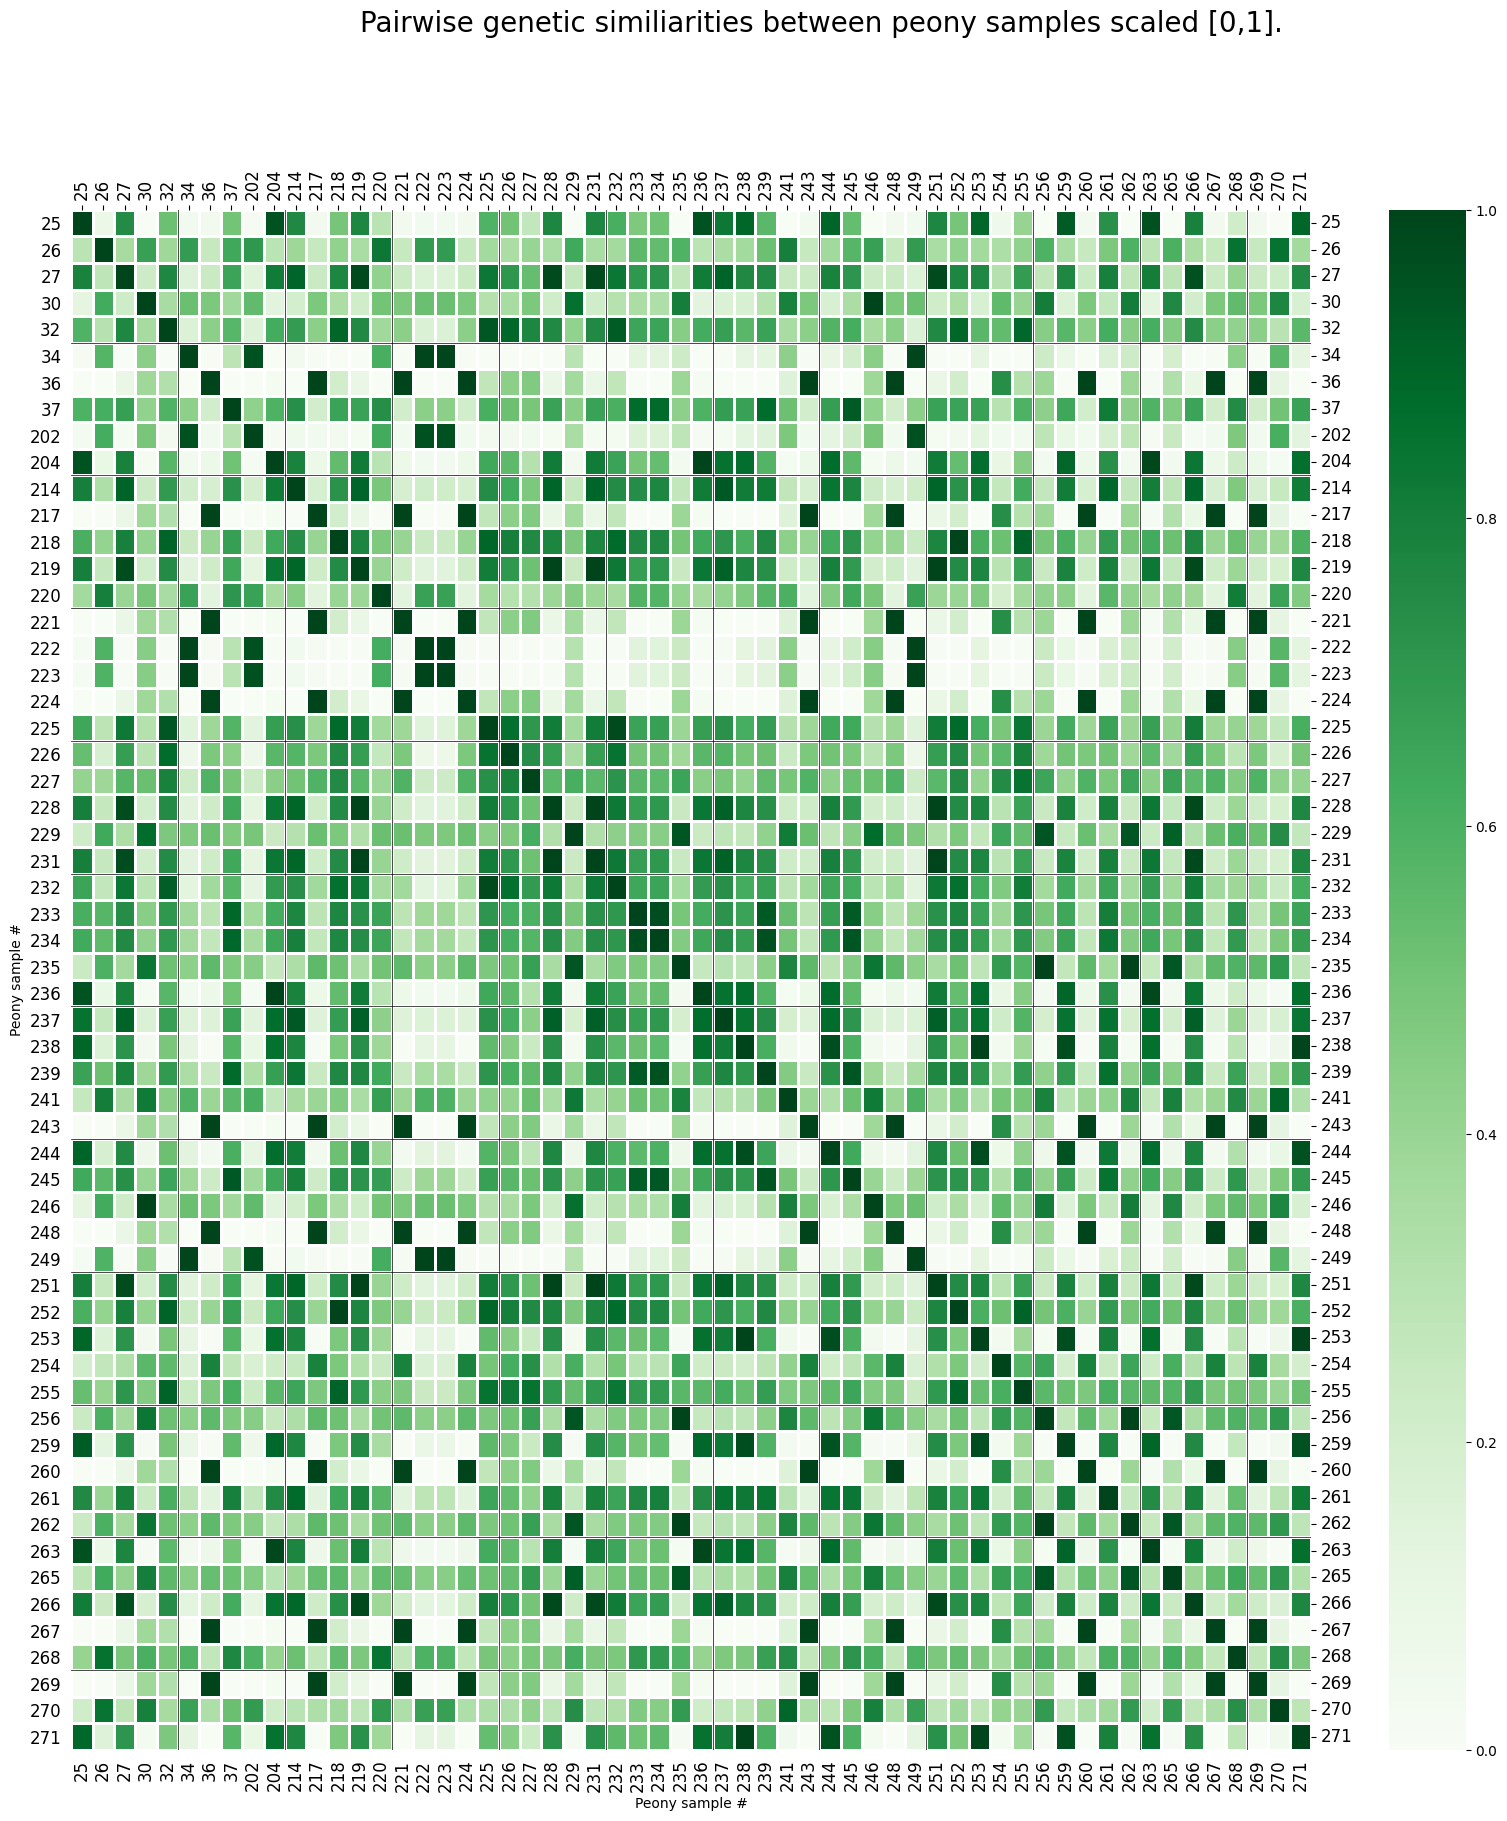

In [5]:
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(figsize=(20,20))
ax.yaxis.tick_right()

#Plotting using the seaborn heatmap function, closer connections depicted with stronger shades of green
sns.heatmap(
    pairwise_scaled_flipped,
    annot=False,
    cmap='Greens',
    linewidth=2,
    square=False
)

#Tweaking the plot
ax.xaxis.tick_top()
ax.tick_params(labeltop=True, labelright=True, labelbottom = True, labelleft = True)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(rotation=90, fontsize = 12)
plt.xlabel("Peony sample #")
plt.ylabel("Peony sample #")
plt.suptitle("Pairwise genetic similiarities between peony samples scaled [0,1].", fontsize = 20)

# Add lines between every 5 rows and columns for readability
for i in range(5, pairwise_scaled_flipped.shape[0], 5):
    plt.axhline(y=i, color='black', linewidth=0.5)
    plt.axvline(x=i, color='black', linewidth=0.5)

plt.show()
#use plt.savefig to save a plot
#plt.savefig("genetic_pairwise.png", dpi = 300)


## Standardizing the numerical features

In [6]:
# Numerical features have to be standardized to compare the features to each other, as the measurements were of different units and magnitudes

measured_data_analysis = measured_data.copy()


measured_data_analysis = measured_data_analysis.drop("SAMPLE", axis=1)


numerics = measured_data_analysis.select_dtypes(exclude=['object'])

numerics_z = stats.zscore(numerics, axis=0, ddof=0,nan_policy="omit")
numerics_z

all_standardized = stats.zscore(measured_data_analysis.select_dtypes(exclude=['object']), axis=0, ddof=0,nan_policy="omit") 

all_standardized = all_standardized.join(measured_data_analysis.select_dtypes(include=['object']))



## Calculating correlations between all features / variables 

In [7]:
# All numeric are now standardized and represented with values of similar scales
correlations = all_standardized.copy()
correlations = correlations.select_dtypes(include=['object']).astype("category").join(correlations.select_dtypes(exclude=['object']))
dummies = pd.get_dummies(correlations.select_dtypes(include=['category']), dtype=int)
data_with_dummies = correlations.select_dtypes(exclude=['category']).join(dummies)
data_standardized_with_dummies = stats.zscore(data_with_dummies, axis=0, ddof=0,nan_policy="omit")
data_standardized_with_dummies_corrw = data_with_dummies.apply(lambda x: data_standardized_with_dummies.corrwith(x))

### Calculation of categorical values frequencies for plotting

In [8]:
#selection of only numeric features
all_standardized_num = all_standardized.select_dtypes(include = ['float'])

#selection of only categorical features
all_standardized_cat = all_standardized.select_dtypes(include = ['object'])

# To list the frequencies of values per each variable, calculate the amounts of values into a list variable list_of_amounts, which is used to create new labels that iclude the amounts of each variable
all_standardized_cat_counts = all_standardized_cat.apply(pd.Series.value_counts)
list_of_amounts = []
for category in all_standardized_num.columns:
    list_of_amounts.extend({str(category)})
for category in all_standardized_cat_counts.columns:
    for value, count in all_standardized_cat_counts[category].items():
        try:
            list_of_amounts.append(f"{category} - {value} ({int(count)})")
        except:
            #Skip rows with nan values for counts
            pass

## Plotting the correlation heat map

<Figure size 2000x2000 with 0 Axes>

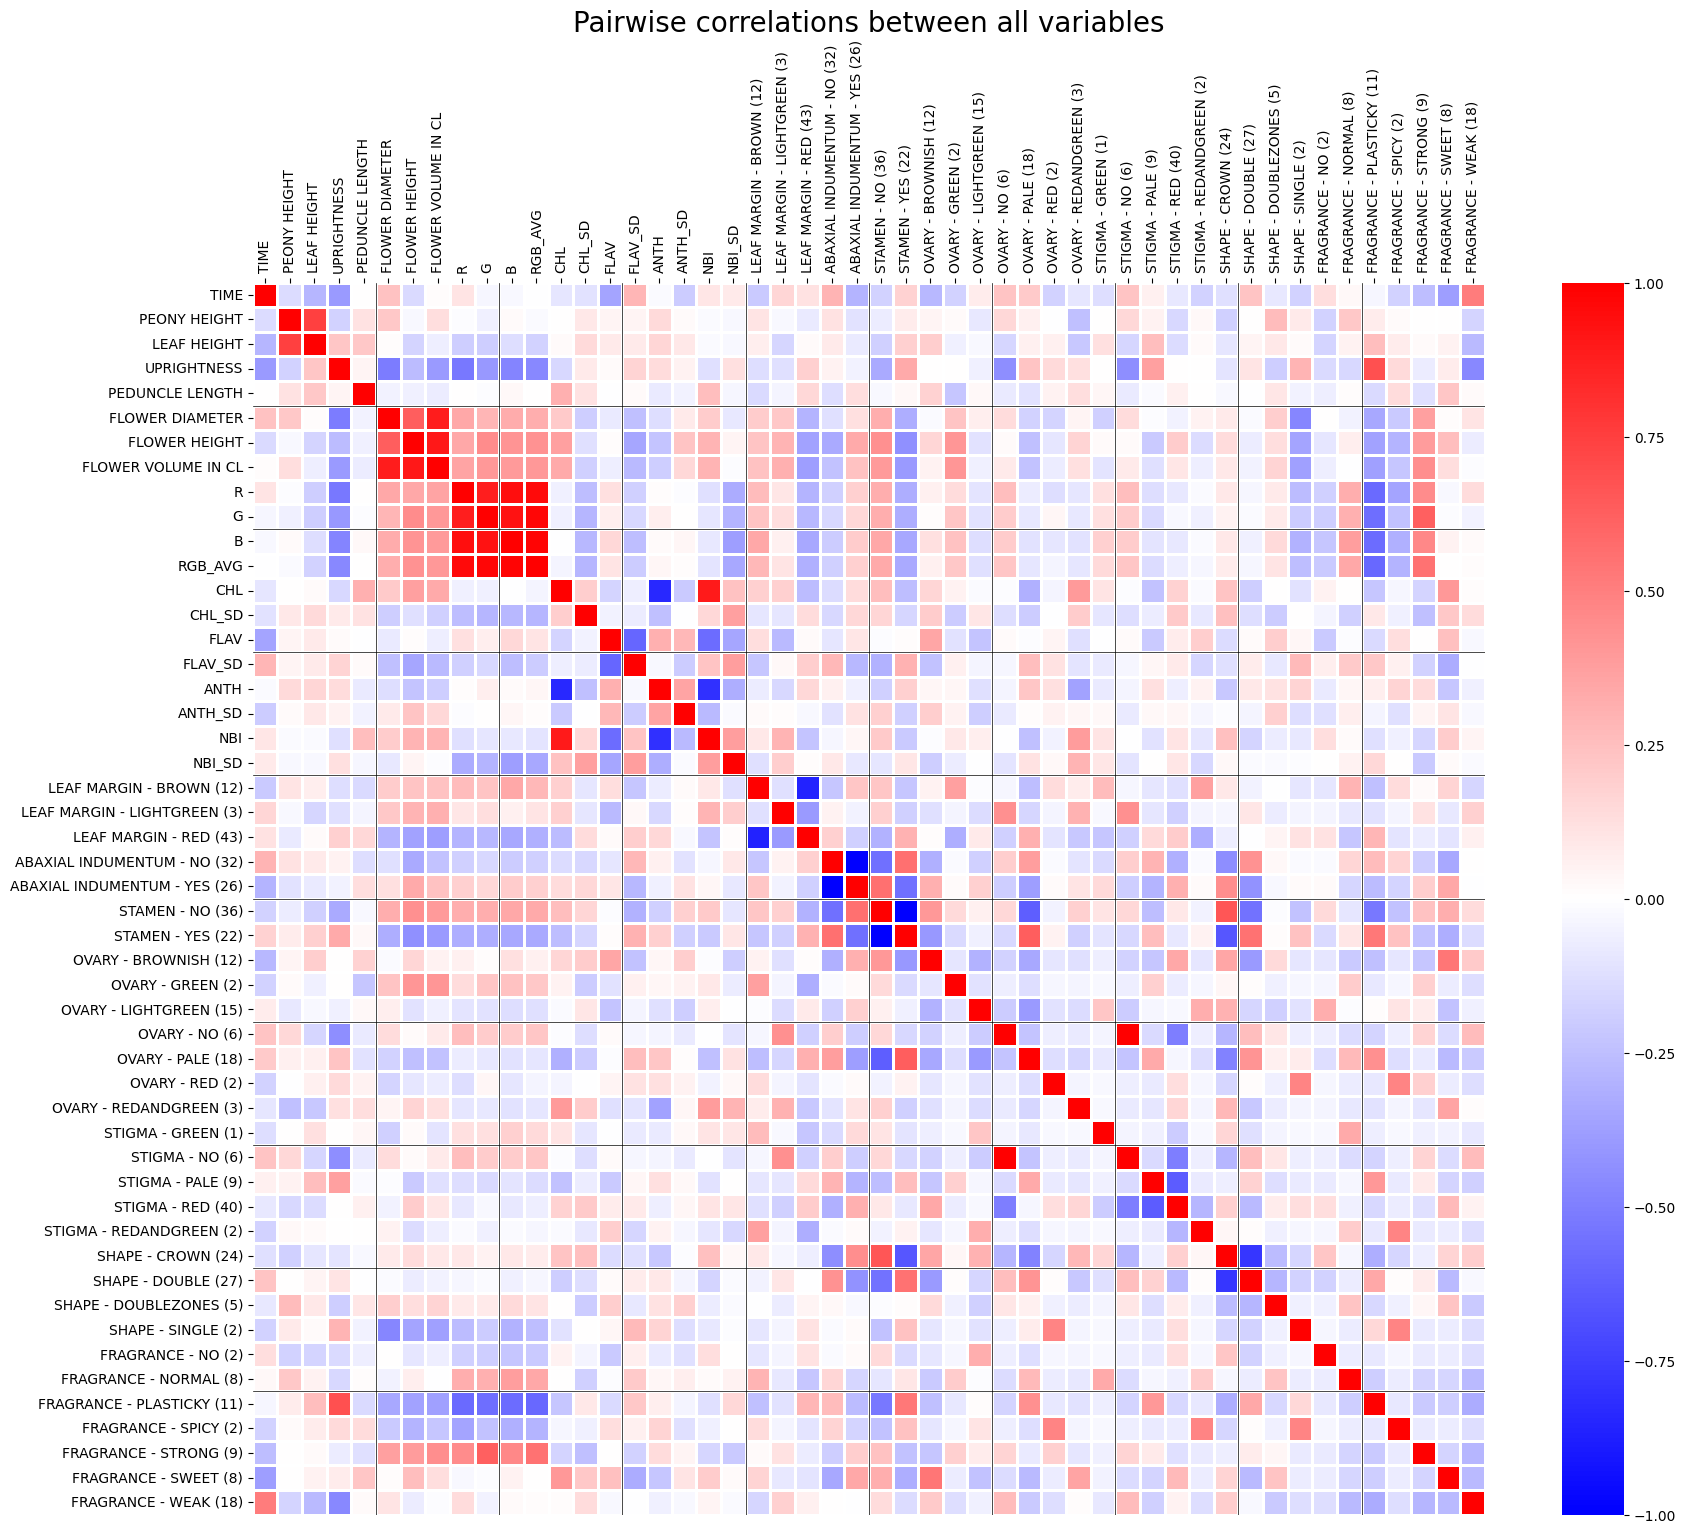

In [9]:
#plot parameters
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(figsize=(20,16))
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')

#calculate correlations between all variables using Pearson correlation
correlationmatrix = data_standardized_with_dummies.corr(method='pearson')



sns.heatmap(
    correlationmatrix,
    xticklabels=list_of_amounts,
    yticklabels=list_of_amounts,
    square=True,
    cmap='bwr',
    cbar= True,
    linewidth=1)

#plt.savefig("correlations_dummattudata_kaikki.png", dpi=300)

# Get the column names from all_standardized_cat
#all_standardized_cat_columns = all_standardized_cat.columns

#ax.set_yticklabels(list_of_amounts)

# Get the existing y-axis tick labels
#existing_labels = [label.get_text() for label in ax.get_yticklabels()]

# Add lines between every 5 rows and columns
for i in range(5, correlationmatrix.shape[0], 5):
    plt.axhline(y=i, color='black', linewidth=0.5)
    plt.axvline(x=i, color='black', linewidth=0.5)

plt.title("Pairwise correlations between all variables", fontsize = 20)

plt.show()

## Importing a genetic marker data file and performing PCA


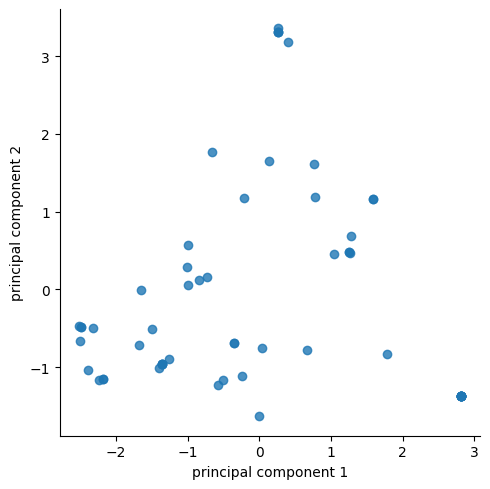

In [11]:
#NOTE This is only for handling of the original genetic data, which has to be included in the directory.
#Uncomment the quotation marks before and after the code below, if original genetic data genetic_data.csv or another file of the same format is present in this directory.
# File has the following columns in csv format: "Sample number", "Original identifier" & separate columnns for each genetic marker with binary values 0 or 1
#Check also the other NOTE for drawing the dendrogram for implementing data from another file.

"""

# Read in the genetic data of samples
with open("genetic_data.csv") as genfile:
    gendf = pd.read_csv(genfile)

gendata = gendf.copy()
gendata["Label"] = gendata["Sample number"].astype(str) + " " + gendata["Original identifier"]

#genfeatures only to contain the genetic marker data without additional columns
genfeatures = list(gendata.columns)
genfeatures.remove("Sample number")
genfeatures.remove("Original identifier")
genfeatures.remove("Label")



#Operations for utilizing the genetic data in form of principal components
#The principal components calculated here were saved to the dataframe of all measurement data for referencing without the original genetic_data.csv file
# PCA operation of genetic features into two principal components
pca = PCA(n_components=2)
genprincipalComponents = pca.fit_transform(gendata[genfeatures])

"""

# Dimension reduced principal components of the genetic data are pulled from the sheet of all measurements
genprincipalDf = pd.DataFrame(data = alldata, columns = ['principal component 1', 'principal component 2'])


# New Dataframe for the pca components and sample
genfinalDf = pd.concat([alldata['SAMPLE'], genprincipalDf], axis = 1)

#Visualization of the distribution of samples in the two dimensions of the principal components
genpca_plot = sns.lmplot( x="principal component 1", y="principal component 2", data=genfinalDf,fit_reg=False)
fig = genpca_plot
#fig.savefig("pca_plot.jpg", dpi = 300)



# Creating dendrograms for visualizing the hierarchy of connections between samples

In [12]:
def get_dendrogram(model, **kwargs):
    # Function for creating a linkage matrix with the chosen model between all the samples and passed arguments

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # return the dendrogram and arguments
    return dendrogram(linkage_matrix, **kwargs)

In [13]:
# Leaf label function llf is used to tweak the samples at the leaves of the dendrogram. It is used to add sample identifiers.

def llf(val):
    haettu_labeli = ""
    haettu_labeli += str(measured_data.iloc[val]["SAMPLE"])
    return haettu_labeli

In [14]:
#Addition of official sample codes used by LUKE for adding them to them plots too
measured_data["LUKE_CODE"] = lukecodes

C:\Users\antti\AppData\Local\Temp\ipykernel_9248\3465298069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measured_data["LUKE_CODE"] = lukecodes


In [15]:
# PLOTTING VALUES OF SAMPLE FEATURES OVER THE DENDROGRAM
# Values of specific features were plotted on top of the dendrogram for the written document using this function.

def add_values_on_dendro():
    """

    #FIRST FIVE CATEGORICALS, UNCOMMENT A FEATURE FOR PLOTTING
    # FRAGRANCE
    ax2.text(6.5, 580.0, f'FRAGRANCE', color='red',weight='bold')
    ax2.text(6.5, -1.0, f'FRAGRANCE', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'FRAGRANCE'].values
        if len(values) > 0:
            ax2.text(6.5, y + 0.5, f'{values[0]}', color='black',weight='bold')

    
    # FLOWER SHAPE
    ax2.text(5, 580.0, f'SHAPE', color='red',weight='bold')
    ax2.text(5, -1.0, f'SHAPE', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'SHAPE'].values
        if len(values) > 0:
            ax2.text(5, y + 0.5, f'{values[0]}', color='black',weight='bold')

    
    # STIGMA
    ax2.text(3.5, 580.0, f'STIGMA', color='red',weight='bold')
    ax2.text(3.5, -1.0, f'STIGMA', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'STIGMA'].values
        if len(values) > 0:
            ax2.text(3.5, y + 0.5, f'{values[0]}', color='black',weight='bold')


    # OVARY
    ax2.text(2, 580.0, f'OVARY', color='red',weight='bold')
    ax2.text(2, -1.0, f'OVARY', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'OVARY'].values
        if len(values) > 0:
            ax2.text(2, y + 0.5, f'{values[0]}', color='black',weight='bold')


    # STAMEN
    ax2.text(0.5, 580.0, f'STAMEN', color='red',weight='bold')
    ax2.text(0.5, -1.0, f'STAMEN', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'STAMEN'].values
        if len(values) > 0:
            ax2.text(0.5, y + 0.5, f'{values[0]}', color='black',weight='bold')
    

    """

    #LATTER FOUR CATEGORICALS, UNCOMMENT TO PLOT
    """
    # UPRIGHTNESS
    ax2.text(6, 580.0, f'UPRIGHTNESS', color='red',weight='bold')
    ax2.text(6, -1.0, f'UPRIGHTNESS', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'UPRIGHTNESS'].values
        if len(values) > 0:
            ax2.text(6, y + 0.5, f'{values[0]}', color='black',weight='bold')

    
    # ABAXIAL INDUMENTUM
    ax2.text(4, 580.0, f'ABAXIAL INDUMENTUM', color='red',weight='bold')
    ax2.text(4, -1.0, f'ABAXIAL INDUMENTUM', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'ABAXIAL INDUMENTUM'].values
        if len(values) > 0:
            ax2.text(4, y + 0.5, f'{values[0]}', color='black',weight='bold')

    
    # LEAF MARGIN
    ax2.text(2, 580.0, f'LEAF MARGIN', color='red',weight='bold')
    ax2.text(2, -1.0, f'LEAF MARGIN', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'LEAF MARGIN'].values
        if len(values) > 0:
            ax2.text(2, y + 0.5, f'{values[0]}', color='black',weight='bold')


    # TIME
    ax2.text(0.5, 580.0, f'TIME', color='red',weight='bold')
    ax2.text(0.5, -1.0, f'TIME', color='red',weight='bold')

    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'TIME'].values
        if len(values) > 0:
            ax2.text(0.5, y + 0.5, f'{values[0]}', color='black',weight='bold')
    """

    # NUMERIC VARIABLES

    """
    # PEONY HEIGHT
    ax2.text(5.5, 582.0, f'LEAF HEIGHT', color='green',weight='bold')

    scale_factor = 180 # adjustable value for scaling the bars
    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'PEONY HEIGHT'].values
        if len(values) > 0:
            ax2.bar(6.6, 3, bottom=y + 0.6, width= -values[0]/scale_factor, color='pink', align='edge', edgecolor ='black')
    avg = measured_data.loc[measured_data['SAMPLE'] == int(label), 'PEONY HEIGHT'].values
    plt.axvline(x=avg, linewidth=2, linestyle='-')

    # LEAVES HEIGHT
    ax2.text(2.5, 582.0, f'PEONY HEIGHT', color='pink',weight='bold')

    scale_factor = 180 # adjustable value for scaling the bars
    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'LEAF HEIGHT'].values
        if len(values) > 0:
            ax2.bar(6.6, 3, bottom=y - 3.4, width= -values[0]/scale_factor, color='green', align='edge', edgecolor ='black')
    

    # PEDUNCLE LENGTH
    ax2.text(5.5, 582.0, f'PEDUNCLE LENGTH', color='blue',weight='bold')
    scale_factor = 2.5 # adjust this value to achieve the desired scaling
    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'PEDUNCLE LENGTH'].values
        if len(values) > 0:
            ax2.bar(6.6, 3, bottom=y + 0.6, width=-values[0]/scale_factor, color='blue', align='edge', edgecolor ='black')

    # FLOWER VOLUME IN CL
    ax2.text(2.5, 582.0, f'FLOWER VOLUME', color='red',weight='bold')
    scale_factor = 30 # adjust this value to achieve the desired scaling
    for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
        values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'FLOWER VOLUME IN CL'].values
        if len(values) > 0:
            ax2.bar(6.6, 3, bottom=y - 3.4, width=-values[0]/scale_factor, color='red', align='edge', edgecolor ='black')

    """
    """
    
    #Vertical lines
    for y in leaf_ycoords:
        ax2.axhline(y+5.4, color='black', linestyle='solid', alpha=0.5, linewidth=1.5)
    #Horizontal lines 
    for x in range(0,6):
        ax2.axvline(x+0, color='gray', linestyle='dashed', alpha=0.5, linewidth=1.5)
    """

## Drawing the main dendrogram depicting the sample set

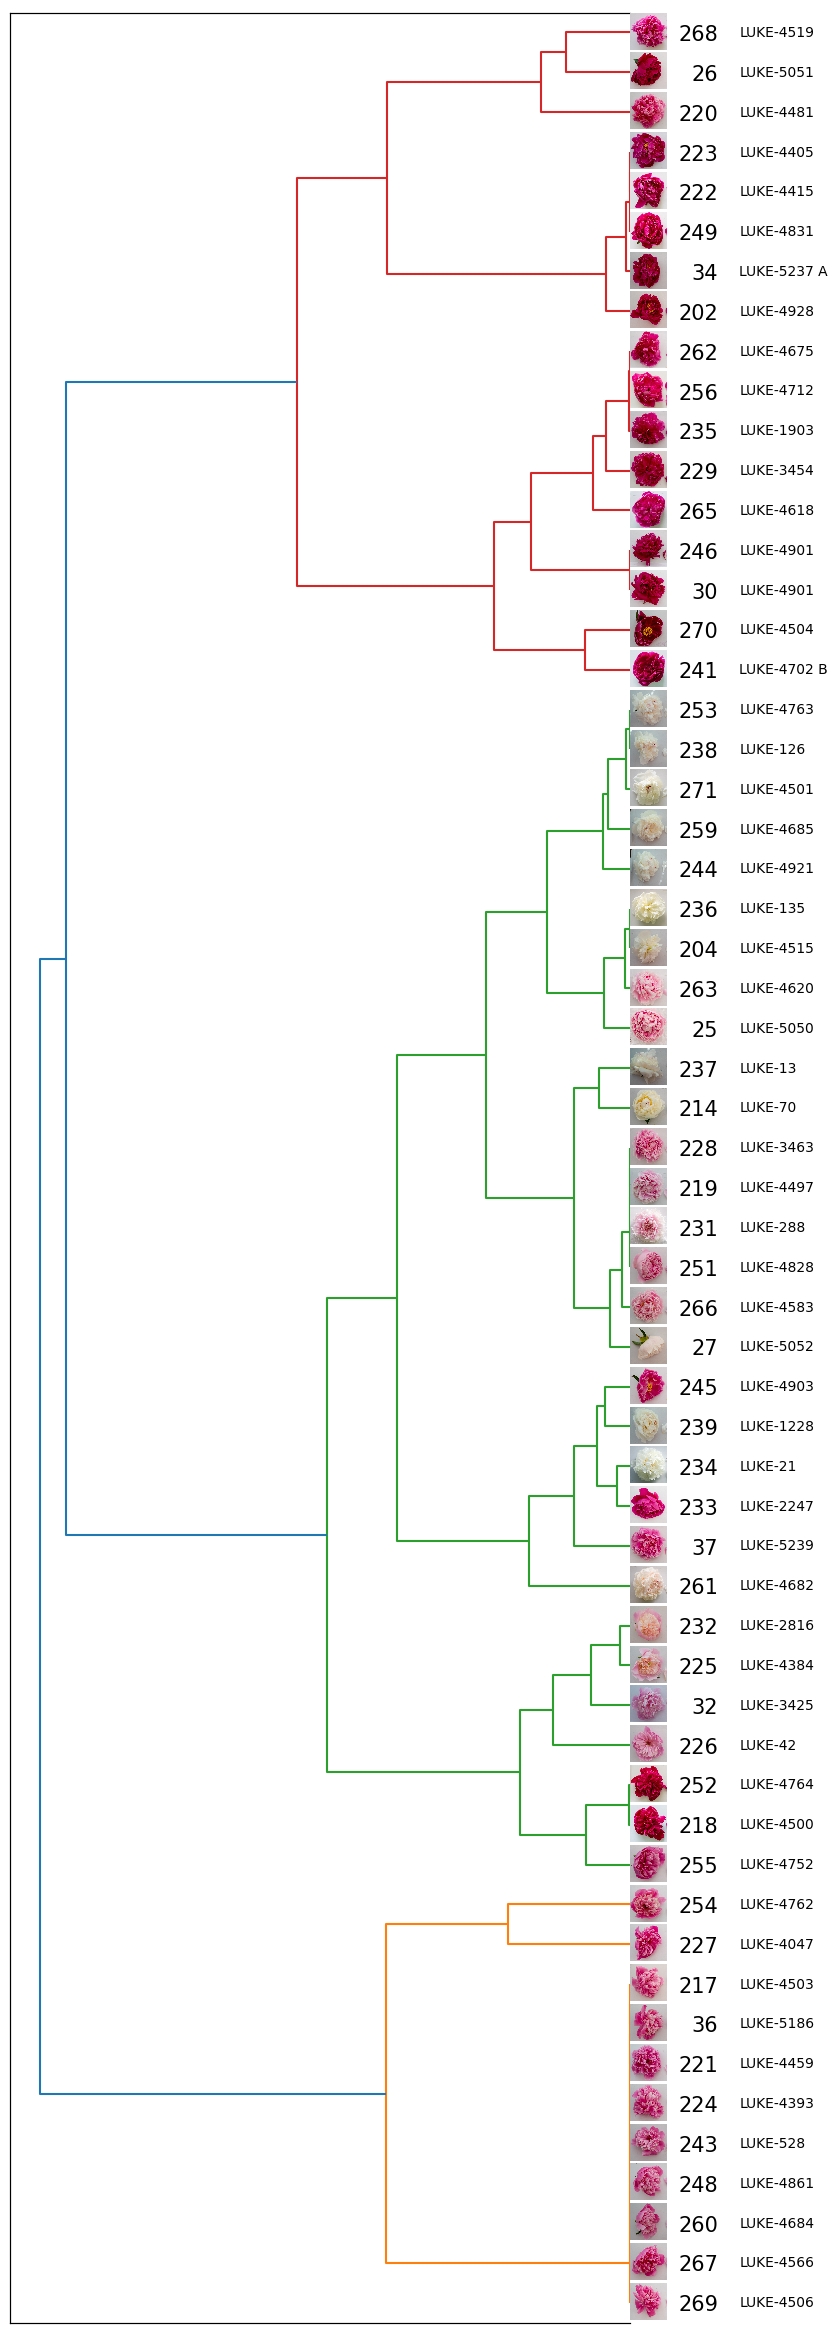

In [16]:
x = genprincipalDf

#NOTE x is the set of data the dendrogram will be formed on if genetic_data.csv is present in the directory comment out the variable above and uncomment the chunk of code below. 

"""
# Using all genetic marker data available
x = gendata[genfeatures]
# Genetic data index labeled with the sample numbers
gendata = gendata.set_index("Sample number")
"""




label_list = alldata["SAMPLE"].tolist()

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete")
model = model.fit(x)


plt.clf()
#plt.figure(figsize=(20,20))
#fig, ax = plt.subplots(figsize=(20,20)

# Form the dendrogram with the chosen model. Font size and orientation were chosen for nice readability.
d = get_dendrogram(model, labels = label_list, orientation = 'left', leaf_font_size =15, leaf_label_func=llf)



# get leaf y-coordinates and labels
ax = plt.gca()


yticks = ax.get_yticks()
leaf_ycoords = [y for y in yticks if y.is_integer()]
leaf_labels = [label.get_text() for label in ax.get_yticklabels()]

# get list of image files in folder
folder_path = 'squarephotos'
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# create a dictionary to map leaf labels to image files
label_to_image = {}
for image_file in image_files:
    filename = os.path.basename(image_file)
    label = filename.split('.')[0]
    label_to_image[label] = image_file

# create a second axes object for plotting images
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(leaf_ycoords)
ax2.set_yticklabels(['' for _ in leaf_ycoords])

# add image annotations to leaves
for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
    xy = (0, y + 3)
    if label in label_to_image:
        arr_img = plt.imread(label_to_image[label])
        imagebox = OffsetImage(arr_img, zoom=0.065)
        ab = AnnotationBbox(imagebox, xy,
                            xybox=(13., -8.),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.3,
                            frameon=False,
                            )
        ax2.add_artist(ab)

# move y-axis labels inside the plot close to the right side
ax.yaxis.set_tick_params(pad=-510)
ax.patch.set_alpha(0.01)


# offset y labels a bit up
offset = transforms.ScaledTranslation(1, 15/72, ax.figure.dpi_scale_trans)
for label in ax.yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

#width = 1
#height = width


# Lisää ylläolevan funktion mukaisesti ominaisuuksia kuvaan
#add_values_on_dendro()

#Modifications
plt.rcParams['lines.linewidth'] = 6
# LUKE-numbers

for i, (y, label) in enumerate(zip(leaf_ycoords, leaf_labels)):
    values = measured_data.loc[measured_data['SAMPLE'] == int(label), 'LUKE_CODE'].values
    if len(values) > 0:
        ax2.text(-1.0, y -1, f'{values[0]}', color='black')


fig=plt.gcf()
ax.spines[['right']].set_visible(False)
ax2.spines[['right']].set_visible(False)


ax.tick_params(axis='y', which='both', length=0)



plt.xticks([])
plt.yticks([])


fig.set_size_inches(8,30)



#UNCOMMENT TO OVERLAY DATA VALUES OR BARS ON TOP OF THE DENDROGRAM BASED ON THE FUNCTIONS SELECTED IN THE PREVIOUS CODE CELL FOR FUNCTION add_values_on_dendro()
#add_values_on_dendro()
#fig.savefig('dendrokuvat_eitekstia.jpg', dpi=100)
plt.show()


### Groups of identical genotypes

In [17]:
measured_data.drop('LUKE_CODE', axis=1)
measured_data.columns

Index(['SAMPLE', 'TIME', 'LEAF MARGIN', 'ABAXIAL INDUMENTUM', 'PEONY HEIGHT',
       'LEAF HEIGHT', 'UPRIGHTNESS', 'PEDUNCLE LENGTH', 'FLOWER DIAMETER',
       'FLOWER HEIGHT', 'FLOWER VOLUME IN CL', 'R', 'G', 'B', 'RGB_AVG',
       'STAMEN', 'OVARY', 'STIGMA', 'SHAPE', 'FRAGRANCE', 'CHL', 'CHL_SD',
       'FLAV', 'FLAV_SD', 'ANTH', 'ANTH_SD', 'NBI', 'NBI_SD', 'LUKE_CODE'],
      dtype='object')

In [18]:
measured_data_analysis = measured_data.copy()
#measured_data_analysis = measured_data_analysis.drop(["sisaTLB","sisaTLR","sisaTLG","ulkoTLB","ulkoTLR","ulkoTLG","LUKE_CODE","Dualex group","NBI_ala", "Flav_ala", "Anth_ala", "Chl_ala","NBI_keski", "Flav_keski", "Anth_keski", "Chl_keski","NBI_yla", "Flav_yla", "Anth_yla", "Chl_yla","NBI_sd", "Flav_sd", "Anth_sd", "Chl_sd"], axis=1)



duplicates_1 = [36,217,221,224,243,248,260,267,269]
duplicates_2 = [219,228,231,251]
duplicates_3 = [222,223,249]
duplicates_4 = [30, 246]
duplicates_all = duplicates_1 + duplicates_2 + duplicates_3
no_duplicates = measured_data_analysis.copy()
no_duplicates = no_duplicates[~no_duplicates['SAMPLE'].isin(duplicates_all)]

group_anum = [232, 225, 226, 32]
group_bnum = [255, 227, 217, 254]
group_cnum = [252, 218]
group_dnum = [236, 204, 25, 263]
group_enum = [253, 238, 271, 244, 259]
group_fnum = [26, 223, 34, 202]
group_gnum = [246, 241, 268]
group_hnum = [233, 262, 256, 235, 229, 265]



# Changing categorical variables with values as numbers to be treated as categorical variables
change_to_cat = ['ABAXIAL INDUMENTUM','TIME','UPRIGHTNESS']

for i in change_to_cat:
    measured_data_analysis[i] = measured_data_analysis[i].astype(object)

In [19]:
no_duplicates = measured_data_analysis.copy()
no_duplicates = no_duplicates[~no_duplicates['SAMPLE'].isin(duplicates_all)]

In [20]:
# Chosen group is a list of sample numbers to calculate pairwise correlations for.
# Name is the name used in the plot to describe the chosen sample group.

def group_correlationheatmap(dataset_standardised, chosen_group, name):

    all_standardized = dataset_standardised.set_index(measured_data["SAMPLE"])

    correlations = all_standardized.copy()
    correlations = correlations.select_dtypes(include=['object']).astype("category").join(correlations.select_dtypes(exclude=['object']))
    dummies = pd.get_dummies(correlations.select_dtypes(include=['category']), dtype=int)
    data_with_dummies = correlations.select_dtypes(exclude=['category']).join(dummies)
    data_standardized_with_dummies = stats.zscore(data_with_dummies, axis=0, ddof=0,nan_policy="omit")
    data_standardized_with_dummies_corrw = data_with_dummies.apply(lambda x: data_standardized_with_dummies.corrwith(x))



    data_standardized_with_dummies = data_standardized_with_dummies.set_index(measured_data["SAMPLE"])
    #FOR DUPLICATE GROUP 1
    valitut = all_standardized.loc[chosen_group]
    valitut_z = data_standardized_with_dummies.loc[chosen_group]

    group_name = name


    plt.figure(figsize=(20,20))
    fig, ax = plt.subplots(figsize=(20,16))
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')

    correlationmatrix = valitut_z.corr(method='pearson')


    data_standardized_with_dummies_corrw = data_with_dummies.apply(lambda x: data_standardized_with_dummies.corrwith(x))


    sns.heatmap(
        correlationmatrix,
        #xticklabels=list_of_amounts,
        #yticklabels=list_of_amounts,
        square=True,
        cmap='bwr',
        cbar= True,
        linewidth=1,
    
    )
    

    #plt.savefig("correlations_dummattudata_kaikki.png", dpi=300)

    # Get the column names from all_standardized_cat
    #all_standardized_cat_columns = all_standardized_cat.columns

    #ax.set_yticklabels(list_of_amounts)

    # Get the existing y-axis tick labels
    #existing_labels = [label.get_text() for label in ax.get_yticklabels()]

    # Add lines between every 5 rows and columns
    for i in range(5, correlationmatrix.shape[0], 5):
        plt.axhline(y=i, color='black', linewidth=0.5)
        plt.axvline(x=i, color='black', linewidth=0.5)

    plt.title(f"Pairwise correlations between measured variables in {group_name}", fontsize = 20)

    plt.show()


<Figure size 2000x2000 with 0 Axes>

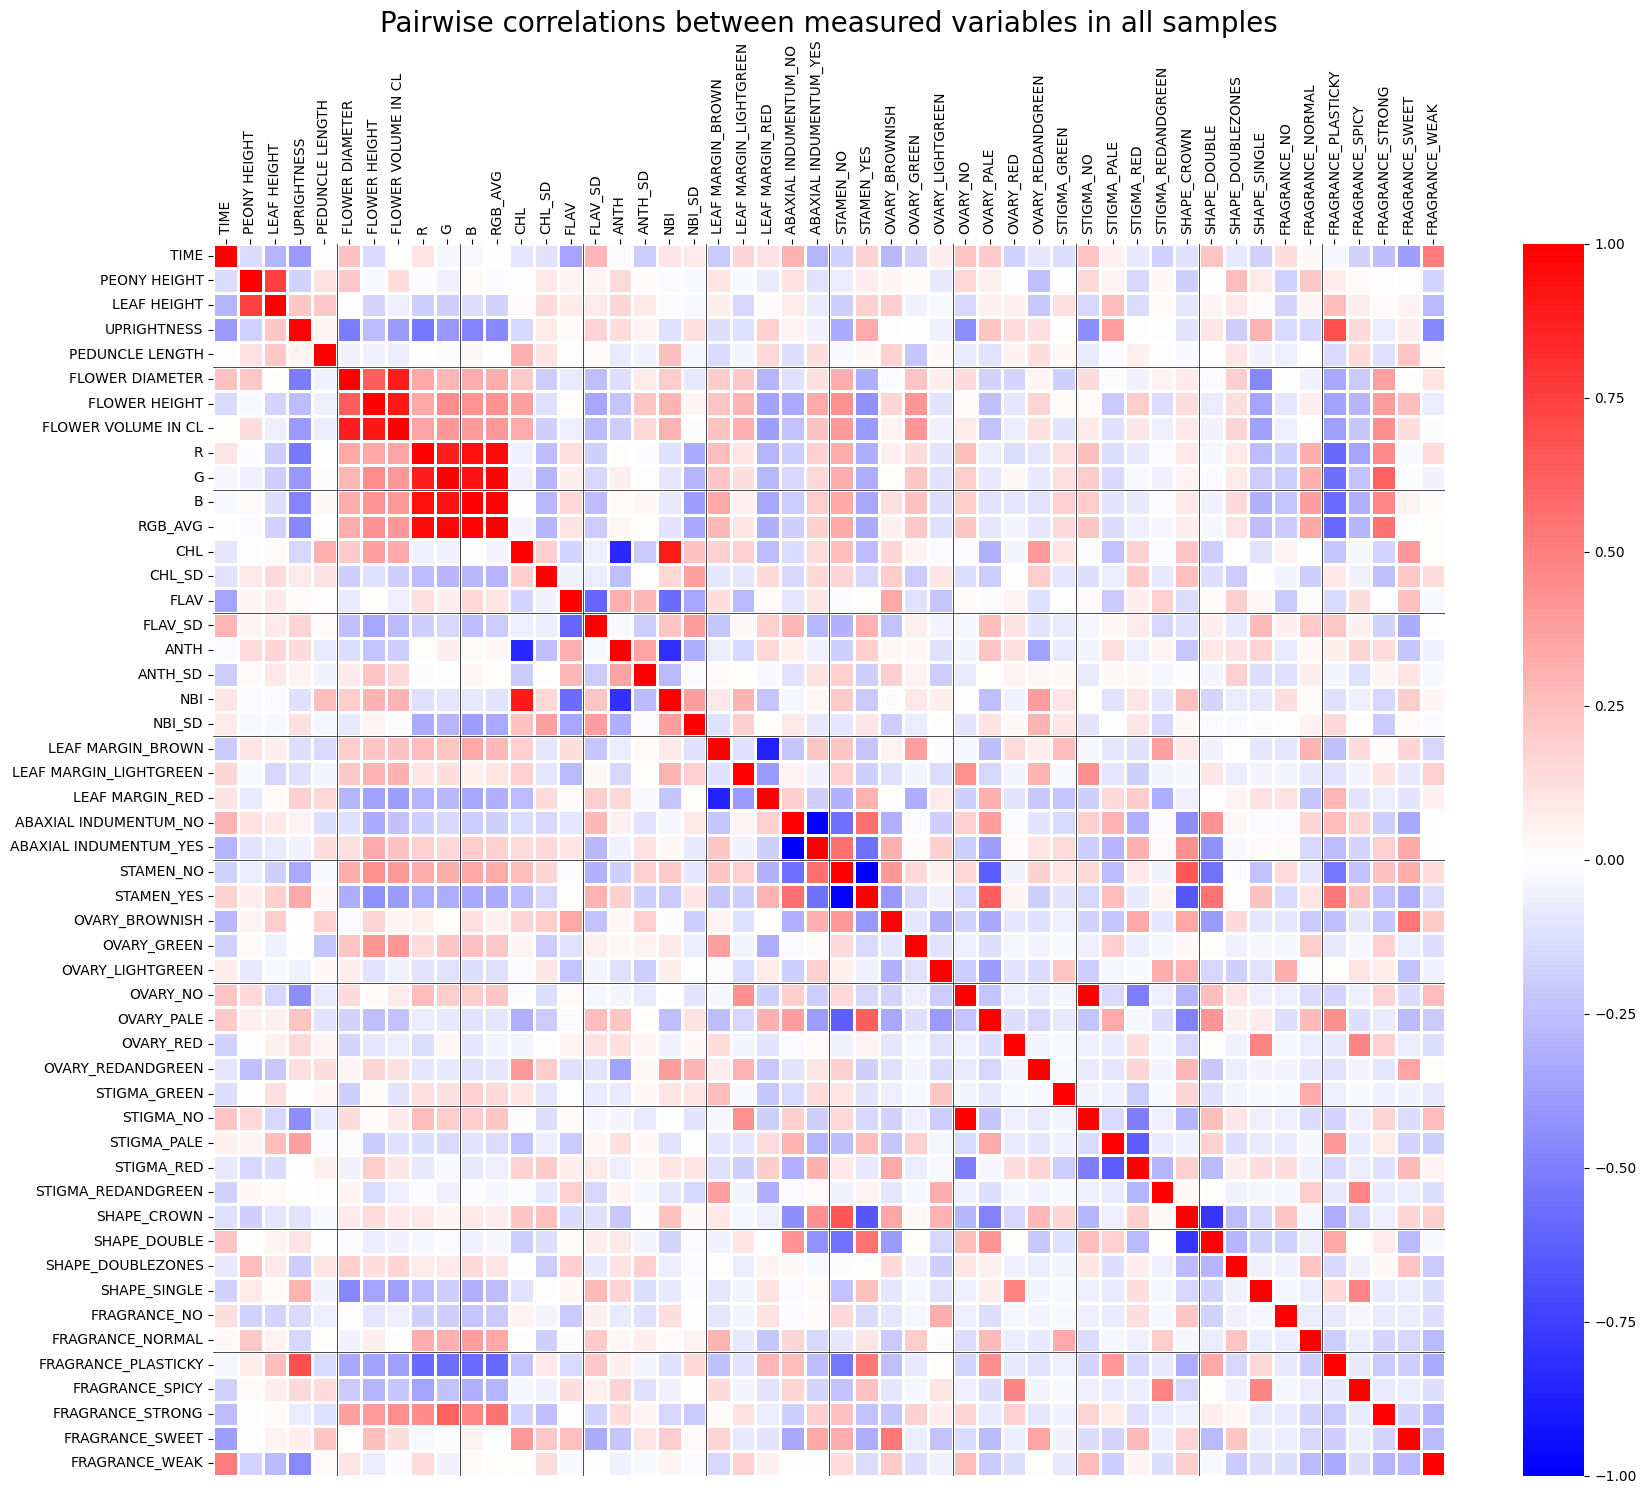

In [21]:
group_correlationheatmap( all_standardized, measured_data["SAMPLE"], "all samples")

In [22]:
measured_data_analysis.columns

Index(['SAMPLE', 'TIME', 'LEAF MARGIN', 'ABAXIAL INDUMENTUM', 'PEONY HEIGHT',
       'LEAF HEIGHT', 'UPRIGHTNESS', 'PEDUNCLE LENGTH', 'FLOWER DIAMETER',
       'FLOWER HEIGHT', 'FLOWER VOLUME IN CL', 'R', 'G', 'B', 'RGB_AVG',
       'STAMEN', 'OVARY', 'STIGMA', 'SHAPE', 'FRAGRANCE', 'CHL', 'CHL_SD',
       'FLAV', 'FLAV_SD', 'ANTH', 'ANTH_SD', 'NBI', 'NBI_SD', 'LUKE_CODE'],
      dtype='object')

In [23]:
group_1 = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(duplicates_1)]
group_2 = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(duplicates_2)]
group_3 = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(duplicates_3)]
group_4 = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(duplicates_4)]
group_a = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(group_anum)]
group_b = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(group_bnum)]
group_c = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(group_cnum)]
group_d = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(group_dnum)]
group_e = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(group_enum)]
group_f = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(group_fnum)]
group_g = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(group_gnum)]
group_h = measured_data_analysis[measured_data_analysis['SAMPLE'].isin(group_hnum)]
allsamples = measured_data_analysis.copy()

In [24]:
def group_x_analysis_tofile(group_x, name):

    # Create a copy of the DataFrame to keep the original unchanged
    group_x_copy = group_x.copy()

    # Remove the column 'paikka'
    if 'SAMPLE' in group_x_copy.columns:
        group_x_copy = group_x_copy.drop(columns=['SAMPLE'])

    if 'LUKE_CODE' in group_x_copy.columns:
        group_x_copy = group_x_copy.drop(columns=['LUKE_CODE'])

    numerical_columns = group_x_copy.select_dtypes(include=['float64', 'int64']).columns 
    categorical_columns = group_x_copy.select_dtypes(include=['object']).columns

    # Calculate coefficients of variation for numerical variables: CoV = Standard Deviation / Mean (* 100%), the multiplication with 100% is not applied for better scaling

    numerical_cv = group_x_copy[numerical_columns].apply(lambda x: (x.std() / x.mean()))

    # Calculate entropy for categorical columns using base 2  (bits)
    categorical_entropy = group_x_copy[categorical_columns].apply(lambda x: entropy (x.value_counts (normalize=True), base=2))

    # Create separate DataFrames
    df1 = pd.DataFrame({'Coefficients of Variation': numerical_cv})
    df2 = pd.DataFrame({'Entropy': categorical_entropy})

    # Combine into a single DataFrame
    group_x_analysis_result = pd.concat([df1, df2])


    # Create a horizontal bar plot
    plt.figure(figsize=(10, 6))
    
    bar1 = plt.barh(numerical_cv.index, numerical_cv, color='blue', alpha=1, label='Numerical')
    bar2 = plt.barh(categorical_entropy.index, categorical_entropy, color='darkgreen', alpha=1, label='Categorical')
    
    plt.xlabel('Coefficients of variation for num. variables and entropy for cat. variables [bits]')
    
    # Variable values next to the bars
    for bar in bar1:
        plt.text(bar.get_width()/1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', ha='left', color='black')
        
    for bar in bar2:
        plt.text(bar.get_width()/1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', ha='left', color='black')

    plt.title(f'{name}: Variability of features')
    
    plt.legend()
    
    plt.show()


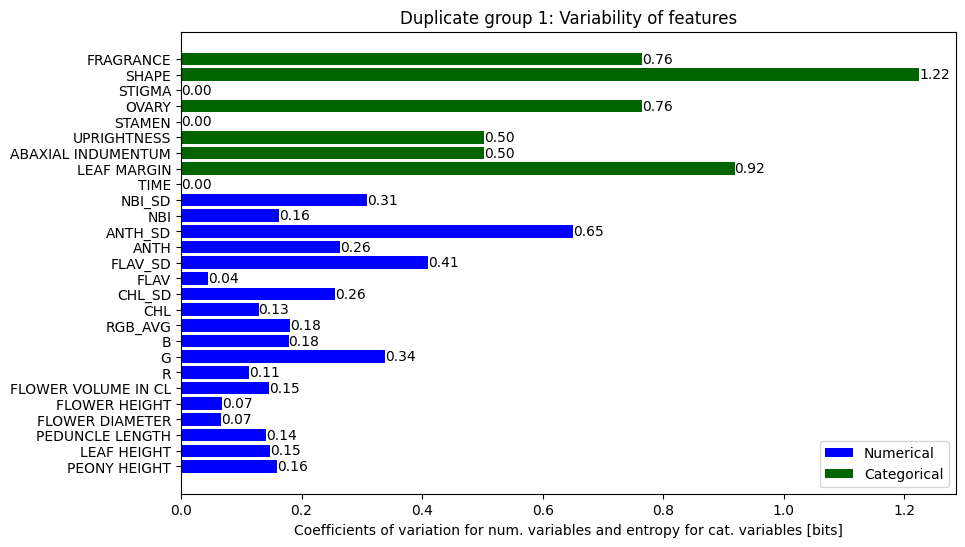

In [25]:
group_x_analysis_tofile(group_1,"Duplicate group 1")